In [145]:
import pandas as pd
import numpy as np
import datetime
import random
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [147]:
import kaleido
import altair as alt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_value = 42
set_seed(seed_value)

In [3]:
zillow = pd.read_parquet('data/zillow.parquet')
sld = pd.read_parquet('data/Smart_Location_Database.parquet')
fips = pd.read_parquet('data/fips.parquet')
fips['FIPS'] = fips['FIPS'].astype('str').str.zfill(5)
food_atlas_df = pd.read_parquet('output/food_atlas_df.parquet')

In [4]:
hv_012023_df = zillow[(zillow.Y==2023) & (zillow.M==1)][['FIPS','Home Value']].dropna(axis=0)

In [5]:
sld_temp_df = sld[['FIPS','NatWalkInd']]
sld_temp_df = sld_temp_df.groupby('FIPS').mean().reset_index()
hv_012023_df = pd.merge(hv_012023_df, sld_temp_df[['FIPS','NatWalkInd']], on='FIPS', how='left')

In [6]:
hv_012023_df = pd.merge(hv_012023_df, food_atlas_df.drop(columns=['State','County']), on='FIPS', how='left')

In [7]:
hv_012023_df.set_index('FIPS', inplace=True)

In [8]:
hv_012023_df.head(5)

,Home Value,NatWalkInd,LowIncTracts_Pct,Urban_Pct,Desert_Pct,LA1and10_Pct,LAhalfand10_Pct,LA1and20_Pct,LATracts_half_Pct,LATracts1_Pct,LATracts10_Pct,LATracts20_Pct,LATractsVehicle_20_Pct,PovertyRate_FIPS
FIPS,,,,,,,,,,,,,,
06037,828060.815041,13.572348,0.487147,0.982434,0.140103,0.124250,0.603685,0.123393,0.602399,0.122965,0.001285,0.000428,0.072408,16.242245
17031,284008.891628,13.635529,0.518265,0.998478,0.156012,0.127854,0.568493,0.127854,0.568493,0.127854,0.000000,0.000000,0.200913,17.140715
48201,279727.962356,11.430193,0.529262,0.974555,0.306616,0.346056,0.843511,0.346056,0.843511,0.346056,0.000000,0.000000,0.153944,17.538931
04013,459750.984210,11.323752,0.364732,0.957284,0.227820,0.378970,0.893757,0.372399,0.882804,0.368018,0.010953,0.004381,0.155531,15.096933
06073,858962.865592,12.186630,0.338118,0.953748,0.090909,0.296651,0.763955,0.291866,0.757576,0.290271,0.006380,0.001595,0.063796,12.543860


In [95]:
df = hv_012023_df

features = df.drop(columns='NatWalkInd').values
targets = df['NatWalkInd'].values
feature_columns = list(df.drop(columns='NatWalkInd').columns)

scaler = StandardScaler()
features = scaler.fit_transform(features)

class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.stop = False
    
    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


# Cross-validation and hyperparameter tuning
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

# param_grid = {
#     'hidden_dim': [5, 10, 20, 40],
#     'dropout_prob': [0.1, 0.2, 0.4, 0.5],
#     'lr': [0.001, 0.01, 0.1]
# }

param_grid = {
    'hidden_dim': [90, 100, 110],
    'dropout_prob': [0.2, 0.3, 0.4, 0.5],
    'lr': [0.01, 0.02 , 0.1]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_params = None
best_val_loss = float('inf')
best_maes = []
best_model = None

start_time_reg = datetime.datetime.now()

best_train_maes = []

for params in ParameterGrid(param_grid):
    fold_losses = []
    train_maes = []
    mae_for_current_hyperparams = []
    jc_mae_list_fold = []
    
    for train_index, val_index in kf.split(features):
        train_features, val_features = features[train_index], features[val_index]
        train_targets, val_targets = targets[train_index], targets[val_index]
        
        model = RegressionModel(input_dim=len(feature_columns), hidden_dim=params['hidden_dim'], dropout_prob=params['dropout_prob']).to(device)
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        early_stopping = EarlyStopping(patience=5)
       
        jc_mae_list_epochs = []
        
        for epoch in range(1000):            
            
            model.train()
            optimizer.zero_grad()
            predictions = model(torch.tensor(train_features, dtype=torch.float).to(device))
            loss = criterion(predictions, torch.tensor(train_targets, dtype=torch.float).unsqueeze(1).to(device))
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                model.eval()
                val_predictions = model(torch.tensor(val_features, dtype=torch.float).to(device))
                mae_for_current_epoch = mean_absolute_error(val_targets, val_predictions.cpu().numpy())
                mae_for_current_hyperparams.append(mae_for_current_epoch)
                val_loss = criterion(val_predictions, torch.tensor(val_targets, dtype=torch.float).unsqueeze(1).to(device))

                jc_mae_list_epochs.append(mae_for_current_epoch)
                
                early_stopping.step(val_loss.item())
                if early_stopping.stop:
                    break
        
        train_predictions = model(torch.tensor(train_features, dtype=torch.float).to(device)).detach()
        fold_train_mae = mean_absolute_error(train_targets, train_predictions.cpu().numpy())
        train_maes.append(fold_train_mae)
        
        fold_losses.append(mean_absolute_error(val_targets, val_predictions.cpu().numpy()))

        jc_mae_list_fold.append(jc_mae_list_epochs)
        
    if np.mean(fold_losses) < best_val_loss:
        best_val_loss = np.mean(fold_losses)
        best_params = params.copy()
        best_maes = fold_losses.copy()
        best_train_maes = train_maes.copy()  # Argh, need copy to get around memory pointers
        mae_for_best_model = mae_for_current_hyperparams.copy()
        jc_best_folds_maes = jc_mae_list_fold.copy()
        #torch.save(model.state_dict(), 'output/pytorch_nn_model_20231015_temp')
        torch.save(model, 'output/pytorch_nn_model_20231015_temp')

print(f"Best model parameters: {best_params}")
print(f"Mean Training MAE across 5 folds for the best model: {np.mean(best_train_maes):.4f}")
print(f"Std Training MAE across 5 folds for the best model: {np.std(best_train_maes):.4f}")
print(f"Mean Test MAE across 5 folds for the best model: {np.mean(best_maes):.4f}")
print(f"Std Test MAE across 5 folds for the best model: {np.std(best_maes):.4f}")

print('The time used for the NN Model is ', datetime.datetime.now()-start_time_reg)

Best model parameters: {'dropout_prob': 0.5, 'hidden_dim': 90, 'lr': 0.1}
Mean Training MAE across 5 folds for the best model: 0.7985
Std Training MAE across 5 folds for the best model: 0.0181
Mean Test MAE across 5 folds for the best model: 0.8136
Std Test MAE across 5 folds for the best model: 0.0530
The time used for the NN Model is  0:00:11.223415


In [96]:
#best_train_maes, best_maes

In [254]:
#jc_best_folds_maes

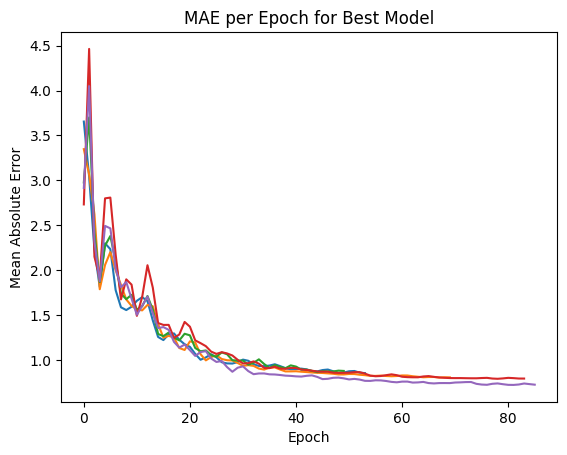

In [98]:
plt.plot(jc_best_folds_maes[0])
plt.plot(jc_best_folds_maes[1])
plt.plot(jc_best_folds_maes[2])
plt.plot(jc_best_folds_maes[3])
plt.plot(jc_best_folds_maes[4])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE per Epoch for Best Model')
plt.show()

In [205]:
epochs_df = pd.melt(pd.DataFrame(jc_best_folds_maes).T, var_name='Fold', value_name='MAE_Score')
epochs_df.dropna(axis=0, inplace=True)
epochs_df.reset_index(drop=True, inplace=True)

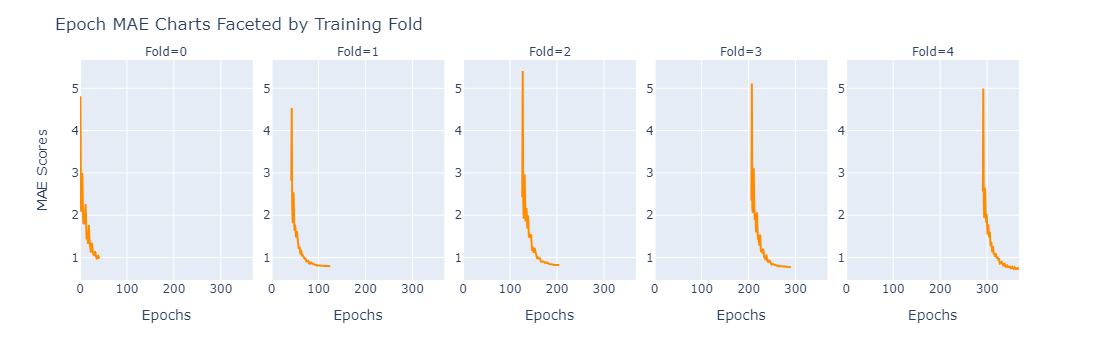

In [211]:
fig = px.line(epochs_df, x=epochs_df.index, y='MAE_Score', facet_col='Fold', color_discrete_sequence=['darkorange'])
fig.update_layout(title='Epoch MAE Charts Faceted by Training Fold')
fig.update_yaxes(title_text='', showticklabels=True)
fig.update_xaxes(title_text='Epochs', showticklabels=True)
fig.update_layout(yaxis_title='MAE Scores')
fig.show()

In [247]:
epoch_color_scale = ['darkblue', 'mediumorchid', 'forestgreen', 'orange', 'darkorange']

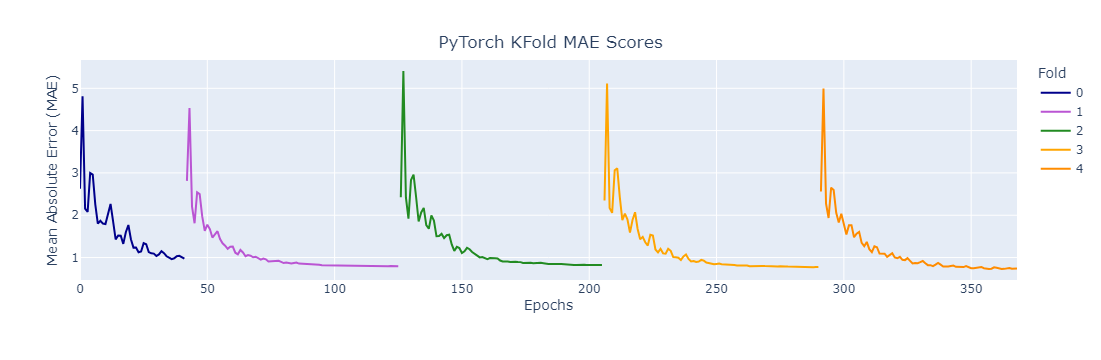

In [253]:
fig = px.line(epochs_df, x=epochs_df.index, y='MAE_Score', color='Fold', color_discrete_sequence=epoch_color_scale)

fig.update_layout(
    title={
        'text': "PyTorch KFold MAE Scores ",
        'x': 0.5,
        'xanchor': 'center',
        'y':0.90,
        'yanchor':'top'
    },
    xaxis=dict(
        title="Epochs",
        title_standoff=5  
    ),
    yaxis=dict(
        title="Mean Absolute Error (MAE)",
        title_standoff=5
    )
)

fig.show()

In [100]:
pyt_model = RegressionModel(input_dim=len(feature_columns), hidden_dim=best_params['hidden_dim'], dropout_prob=best_params['dropout_prob']).to(device)
pyt_model.load_state_dict(torch.load('output/pytorch_nn_model_20231015_1035'))
#pyt_model.eval()

<All keys matched successfully>

WORKING VERSION, INCLUDES SAVING FULL MODEL TO DISK AND MAE PER EPOCH PER FOLD

In [136]:
df = hv_012023_df

features = df.drop(columns='NatWalkInd').values
targets = df['NatWalkInd'].values
feature_columns = list(df.drop(columns='NatWalkInd').columns)

scaler = StandardScaler()
features = scaler.fit_transform(features)

class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.stop = False
    
    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

# param_grid = {
#     'hidden_dim': [5, 10, 20, 40],
#     'dropout_prob': [0.1, 0.2, 0.4, 0.5],
#     'lr': [0.001, 0.01, 0.1]
# }

param_grid = {
    'hidden_dim': [90, 100, 110],
    'dropout_prob': [0.2, 0.3, 0.4, 0.5],
    'lr': [0.01, 0.02 , 0.1]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_params = None
best_val_loss = float('inf')
best_maes = []
best_model = None

start_time_reg = datetime.datetime.now()

best_train_maes = [] 

for params in ParameterGrid(param_grid):
    fold_losses = []
    train_maes = []  
    mae_for_current_hyperparams = []
    jc_mae_list_fold = []
    
    for train_index, val_index in kf.split(features):
        train_features, val_features = features[train_index], features[val_index]
        train_targets, val_targets = targets[train_index], targets[val_index]
        
        model = RegressionModel(input_dim=len(feature_columns), hidden_dim=params['hidden_dim'], dropout_prob=params['dropout_prob']).to(device)
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        early_stopping = EarlyStopping(patience=5)

        jc_mae_list_epochs = []
        
        for epoch in range(1000):            
            
            model.train()
            optimizer.zero_grad()
            predictions = model(torch.tensor(train_features, dtype=torch.float).to(device))
            loss = criterion(predictions, torch.tensor(train_targets, dtype=torch.float).unsqueeze(1).to(device))
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                model.eval()
                val_predictions = model(torch.tensor(val_features, dtype=torch.float).to(device))
                mae_for_current_epoch = mean_absolute_error(val_targets, val_predictions.cpu().numpy())
                mae_for_current_hyperparams.append(mae_for_current_epoch)
                val_loss = criterion(val_predictions, torch.tensor(val_targets, dtype=torch.float).unsqueeze(1).to(device))

                jc_mae_list_epochs.append(mae_for_current_epoch)
                
                early_stopping.step(val_loss.item())
                if early_stopping.stop:
                    break
        
        train_predictions = model(torch.tensor(train_features, dtype=torch.float).to(device)).detach()
        fold_train_mae = mean_absolute_error(train_targets, train_predictions.cpu().numpy())
        train_maes.append(fold_train_mae)
        
        fold_losses.append(mean_absolute_error(val_targets, val_predictions.cpu().numpy()))

        jc_mae_list_fold.append(jc_mae_list_epochs)
        
    if np.mean(fold_losses) < best_val_loss:
        best_val_loss = np.mean(fold_losses)
        best_params = params.copy()
        best_maes = fold_losses.copy()
        best_train_maes = train_maes.copy() # Argh, need copy to get around memory pointers
        mae_for_best_model = mae_for_current_hyperparams.copy()
        jc_best_folds_maes = jc_mae_list_fold.copy()
        #torch.save(model.state_dict(), 'output_v2/pytorch_nn_model_20231015_1035')
        torch.save(model, 'output/pytorch_nn_model_20231015_1046')


print(f"Best model parameters: {best_params}")
print(f"Mean Training MAE across 5 folds for the best model: {np.mean(best_train_maes):.4f}")
print(f"Std Training MAE across 5 folds for the best model: {np.std(best_train_maes):.4f}")
print(f"Mean Test MAE across 5 folds for the best model: {np.mean(best_maes):.4f}")
print(f"Std Test MAE across 5 folds for the best model: {np.std(best_maes):.4f}")

print('The time used for the NN Model is ', datetime.datetime.now()-start_time_reg)

Best model parameters: {'dropout_prob': 0.4, 'hidden_dim': 110, 'lr': 0.1}
Mean Training MAE across 5 folds for the best model: 0.7980
Std Training MAE across 5 folds for the best model: 0.0503
Mean Test MAE across 5 folds for the best model: 0.8222
Std Test MAE across 5 folds for the best model: 0.0797
The time used for the NN Model is  0:00:12.178101


In [146]:
# with open('output/pyt_test_maes.pkl', 'wb') as f:  # Best PyTorch Model Test MAEs
#   pickle.dump(best_maes, f)
# with open('output/pyt_train_maes.pkl', 'wb') as f:  # Best PyTorch Model Train MAEs
#   pickle.dump(best_train_maes, f)
# with open('output/pyt_model_folds_epoch_maes.pkl', 'wb') as f:  # Best PyTorch Model Train Epoch MAEs
#   pickle.dump(jc_best_folds_maes, f)

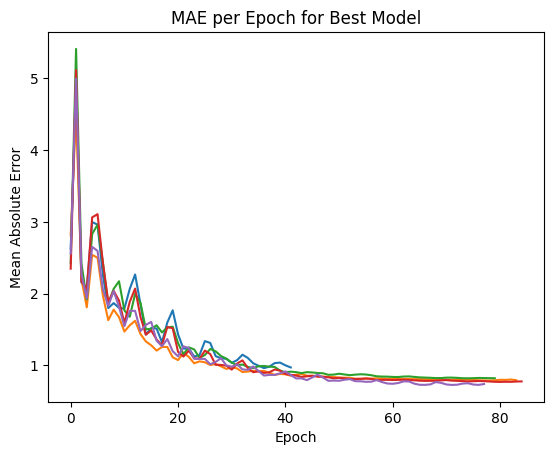

In [137]:
plt.plot(jc_best_folds_maes[0])
plt.plot(jc_best_folds_maes[1])
plt.plot(jc_best_folds_maes[2])
plt.plot(jc_best_folds_maes[3])
plt.plot(jc_best_folds_maes[4])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE per Epoch for Best Model')
plt.show()

In [129]:
#pyt_model = RegressionModel(input_dim=len(feature_columns), hidden_dim=best_params['hidden_dim'], dropout_prob=best_params['dropout_prob']).to(device)
pyt_model = torch.load('output/pytorch_nn_model_20231015_1046')
#pyt_model.eval()

In [131]:
#pyt_model.state_dict()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e75edf0e-32f1-42b8-8a27-9dc0078a206d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>